In [2]:
%matplotlib inline

import numpy as np
import pylab as plt


In [3]:
data = np.genfromtxt('data/gc-hb-rgb.txt',names=True,dtype=None)
# Select metal-poor clusters
d = data[data['feh_gc97'] <= -1.1]

weights = 1./d['sigma']**2
wavg = np.average(d['R'],weights=weights)
wavg_err = 1./np.sqrt(np.sum(weights))

label = "R_avg = %.2f +/- %.2f"%(wavg,wavg_err)
print(label)




R_avg = 1.39 +/- 0.03


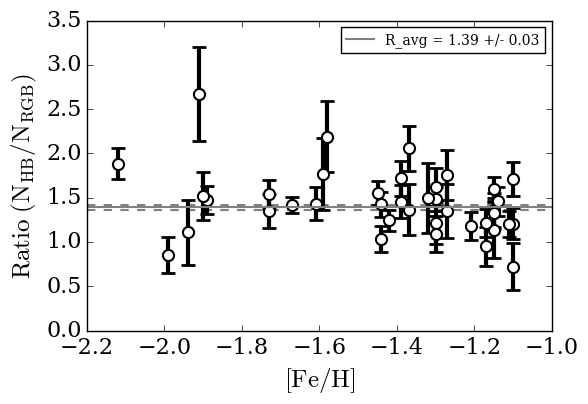

In [11]:
plt.figure()
plt.errorbar(x=d['feh_gc97'],y=d['R'],yerr=d['sigma'],marker='o',ls='',ms=8, capthick=2,elinewidth=3,capsize=5,mfc='w',c='k',mew=1.5)
plt.ylabel(r'${\rm Ratio\ (N_{HB}/N_{RGB})}$',fontsize=18)
plt.xlabel(r'${\rm [Fe/H]}$',fontsize=18)
plt.axhline(wavg,c='gray',ls='-',lw=1.5,label=label)
plt.axhline(wavg+wavg_err,ls='--',c='gray',lw=1.5,zorder=-1)
plt.axhline(wavg-wavg_err,ls='--',c='gray',lw=1.5,zorder=-1)
plt.legend()